In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [28]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score
from functools import partial

# Historical Prices from Yahoo, Ebay, etc.

In [3]:
prices = pd.read_csv('./tsa_prices.csv', index_col=0)
prices.index = pd.to_datetime(prices.index)
print(prices.shape)
prices.head()

(1278, 2)


,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


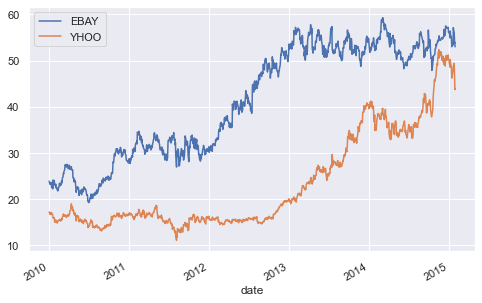

In [4]:
# plot the raw values over time
prices.plot(figsize=(8, 5))
plt.show()

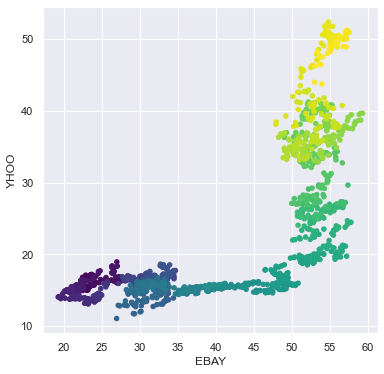

In [5]:
# scatterplot with color relating to time
prices.plot(x='EBAY',
            y='YHOO',
            c=prices.index,
            cmap=plt.cm.viridis,
            kind='scatter',
            colorbar=False,
            figsize=(6, 6))
plt.show()

## Fitting a simple regression model

Now, let's attempt to predict the value of Apple using the values of NVidia, Ebay, and Yahoo.

In [6]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [7]:
all_prices = pd.read_csv('./all_prices.csv')
print(all_prices.shape)
all_prices.head()

(1278, 51)


,date,AAPL,ABT,AIG,AMAT,ARNC,BAC,BSX,C,CHK,CMCSA,CSCO,DAL,EBAY,F,FB,FCX,FITB,FOXA,FTR,GE,GILD,GLW,GM,HAL,HBAN,HPE,HPQ,INTC,JPM,KEY,KMI,KO,MRK,MRO,MSFT,MU,NFLX,NVDA,ORCL,PFE,QCOM,RF,SBUX,T,V,VZ,WFC,XOM,XRX,YHOO
0,2010-01-04,214.009998,54.459951,29.889999,14.30,16.650013,15.690000,9.01,3.40,28.090001,16.969999,24.690001,11.22,23.900000,10.28,NaN,83.459999,10.12,13.929995,7.96,15.45,43.299999,19.559999,NaN,31.250000,3.68,NaN,52.449999,20.879999,42.849998,5.94,NaN,57.040001,37.009998,32.110070,30.950001,10.85,53.479999,18.490000,24.850000,18.930000,46.939999,5.42,23.049999,28.580000,88.139999,33.279869,27.320000,69.150002,8.63,17.100000
1,2010-01-05,214.379993,54.019953,29.330000,14.19,16.130013,16.200001,9.04,3.53,28.970002,16.740000,24.580000,12.10,23.650000,10.96,NaN,83.959999,10.39,13.970000,7.91,15.53,43.259998,19.629999,NaN,31.650000,3.76,NaN,52.669998,20.870001,43.680000,6.17,NaN,56.349998,37.160000,32.140079,30.959999,11.17,51.510001,18.760000,24.820000,18.660000,48.070000,5.60,23.590000,28.440001,87.129997,33.339868,28.070000,69.419998,8.64,17.230000
2,2010-01-06,210.969995,54.319953,29.139999,14.16,16.970013,16.389999,9.16,3.64,28.650002,16.620001,24.420000,12.11,23.500000,11.37,NaN,87.309998,10.45,14.200000,7.80,15.45,44.759998,19.379999,NaN,32.400002,3.86,NaN,52.179999,20.799999,43.919998,6.13,NaN,56.330002,37.660000,32.850072,30.770000,11.22,53.319999,18.879999,24.459999,18.600000,47.599998,5.67,23.420000,27.610001,85.959999,31.919873,28.110001,70.019997,8.56,17.170000
3,2010-01-07,210.580000,54.769952,28.580000,14.01,16.610014,16.930000,9.09,3.65,28.720002,16.969999,24.530001,12.69,23.229998,11.66,NaN,85.639999,11.08,13.999998,7.76,16.25,44.869999,19.570000,NaN,32.480000,4.29,NaN,52.199999,20.600000,44.790001,6.39,NaN,56.189999,37.720001,32.650089,30.450001,10.84,52.400001,18.510000,24.379999,18.530001,48.980000,6.17,23.360001,27.299999,86.760002,31.729875,29.129999,69.800003,8.60,16.700001
4,2010-01-08,211.980005,55.049952,29.340000,14.55,17.020014,16.780001,9.00,3.59,28.910002,16.920000,24.660000,12.47,23.509999,11.69,NaN,88.099998,11.09,14.120002,7.68,16.60,44.540001,19.889999,NaN,34.119999,4.22,NaN,52.589997,20.830000,44.680000,6.50,NaN,55.150002,37.700001,32.700080,30.660000,11.10,53.300002,18.549999,24.680000,18.680000,49.470001,6.18,23.280001,27.100000,87.000000,31.749874,28.860001,69.519997,8.57,16.700001


In [8]:
# use stock symbols to extract training data
X = all_prices[['EBAY', 'NVDA', 'YHOO']]
y = all_prices[['AAPL']]

# fit and score the model with cv
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


As you can see, fitting a model with raw data doesn't give great results.

## Visualizing predicted values

In [9]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# fit model and generate predictions
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(score)

-0.33806972562289417


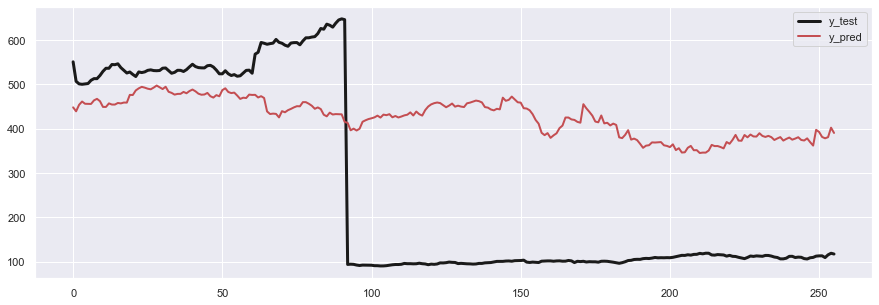

In [10]:
# Visualize our predictions along with the true values
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(range(len(y_test)), y_test, color='k', lw=3, label='y_test')
ax.plot(range(len(y_pred)), y_pred, color='r', lw=2, label='y_pred')

plt.legend()
plt.show()

## Visualizing messy data

In [11]:
prices_messy = pd.read_csv('./prices_null.csv', index_col=0)
prices_messy.index = pd.to_datetime(prices_messy.index)
print(prices_messy.shape)
prices_messy.head()

(1762, 3)


,EBAY,NVDA,YHOO
date,,,
2010-01-04,23.900000,18.490000,17.100000
2010-01-05,23.650000,18.760000,17.230000
2010-01-06,23.500000,18.879999,17.170000
2010-01-07,23.229998,18.510000,16.700001
2010-01-08,23.509999,18.549999,16.700001


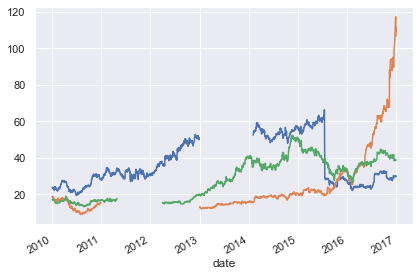

EBAY    273
NVDA    502
YHOO    232
dtype: int64


In [12]:
# visualize the dataset
prices_messy.plot(legend=False)
plt.tight_layout()
plt.show()

# count the mssing values of each time series
print(prices_messy.isna().sum())

## Imputing missing values

In [13]:
# create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):
    # create a boolean mask for missing values
    missing_values = prices.isna()
    
    # interpolate the missing values
    prices_interp = prices.interpolate(interpolation)
    
    # plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    
    prices_interp.plot(color='k',
                       alpha=0.6,
                       ax=ax, 
                       legend=False)
    
    # now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax,
                                       color='r',
                                       lw=3,
                                       legend=False)
    
    plt.show()

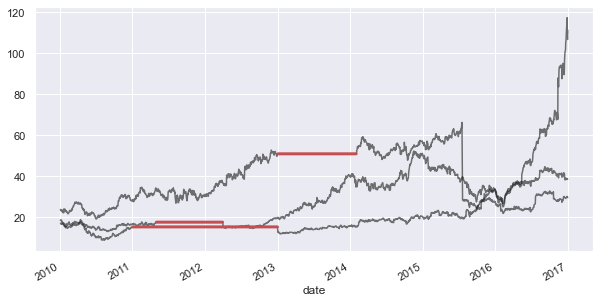

In [15]:
# interpolate using the latest non_missing value
interpolate_and_plot(prices_messy, 'zero')

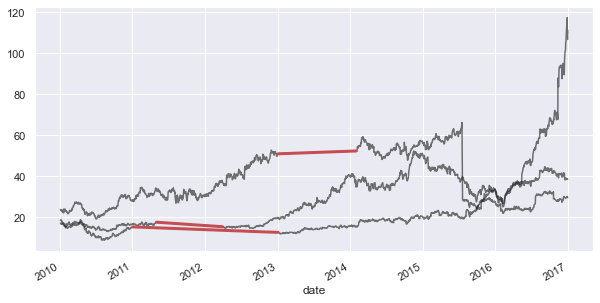

In [16]:
# interpolate linearly
interpolate_and_plot(prices_messy, 'linear')

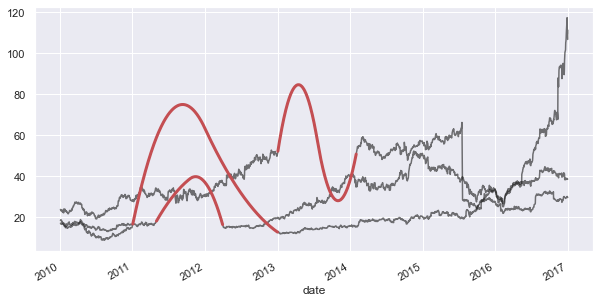

In [17]:
# interpolate with a quadratic function
interpolate_and_plot(prices_messy, 'quadratic')

## Transforming raw data
Define a function that calculates the percent change over a rolling window

In [18]:
# your custom function
def percent_change(series):
    # collect all but the last value of this window, then the final value
    prev_vals = series[:-1]
    last_val = series[-1]
    
    # calculate the %change between the last val and mean of prev vals
    percent_change = (last_val - np.mean(prev_vals)) / np.mean(prev_vals)
    
    return percent_change

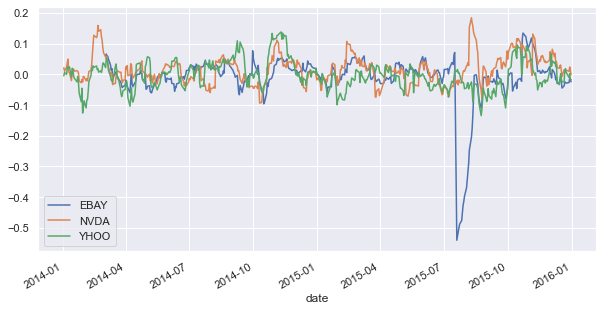

In [21]:
# apply fxn and plot
prices_perc = prices_messy.rolling(20).aggregate(percent_change)
prices_perc.loc['2014': '2015'].plot(figsize=(10, 5))
plt.show()

## Handling outliers

Define a function that:
 * obtains the absolute value of each datapoint's distance from the mean, then create a boolean mask for points that are three times the std from the mean
 * use this boolean mask to replace the outliers with the median of the entire series.

In [22]:
def replace_outliers(series):
    # calculate the absolute difference of each point from the series mean
    abs_diff_from_mean = np.abs(series - np.mean(series))
    
    # calculate a mask for the diff that are > 3 standard deviations from mean
    this_mask = abs_diff_from_mean > (np.std(series) * 3)
    
    # replace these values with the median across the data
    series[this_mask] = np.nanmedian(series)
    
    return series

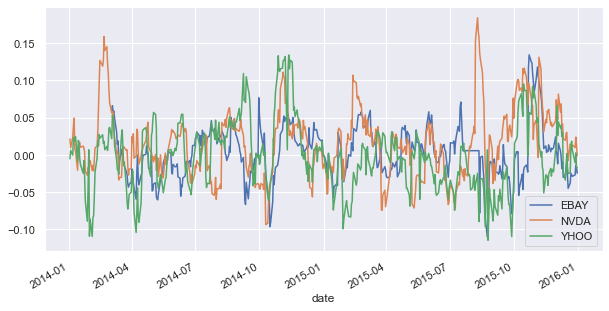

In [23]:
# apply preprocessing fxn to timeseries and plot
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc['2014':'2015'].plot(figsize=(10, 5))
plt.show()

## Engineering multiple rolling features at once

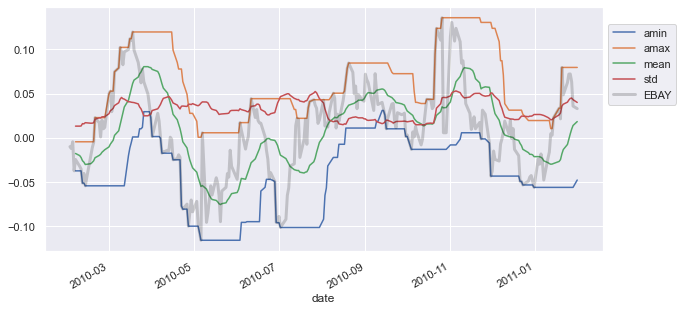

In [27]:
# choose ebay from prices_perc
# define a rolling window with pandas, excluding the right-most
# datapoint of the window
prices_perc_rolling = prices_perc['EBAY'].rolling(20, 
                                                  min_periods=5,
                                                  closed='right')

# define features to be calculated
f_to_calc = [np.min, np.max, np.mean, np.std]

# calculate these features for the rolling window obj
features = prices_perc_rolling.aggregate(f_to_calc)

# plot the results
fig, ax = plt.subplots(figsize=(10, 5))

features.loc[:'2011-01'].plot(ax=ax)
prices_perc['EBAY'].loc[:'2011-01'].plot(ax=ax,
                                         color='k',
                                         alpha=0.2,
                                         lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

## Percentiles and partial functions

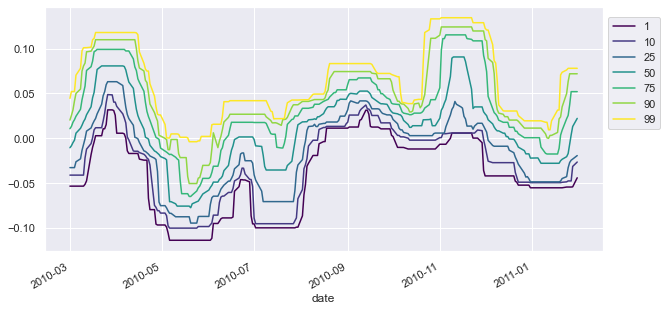

In [29]:
percentiles = [1, 10, 25, 50, 75, 90, 99]

# create partial fxn for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# calculate each of these quantiles on the data using the rolling window
prices_perc_rolling = prices_perc['EBAY'].rolling(20, 
                                                  min_periods=5,
                                                  closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# plot a subset of the result
fig, ax = plt.subplots(figsize=(10, 5))

features_percentiles.loc[:'2011-01'].plot(ax=ax,
                                          cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))

plt.show()

## Using 'date' information

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2016-12-16', '2016-12-19', '2016-12-20', '2016-12-21',
               '2016-12-22', '2016-12-23', '2016-12-27', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='date', length=1762, freq=None)

In [36]:
# extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.weekday
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

prices_perc.tail()

,EBAY,NVDA,YHOO,day_of_week,week_of_year,month_of_year
date,,,,,,
2016-12-23,0.024842,0.147720,-0.038006,4,51,12
2016-12-27,0.038030,0.014446,-0.027985,1,52,12
2016-12-28,0.026925,0.117737,-0.029311,2,52,12
2016-12-29,0.021850,0.129669,-0.028632,3,52,12
2016-12-30,0.007285,0.068559,-0.026603,4,52,12
